In [2]:
!pip install datasets
from datasets import load_dataset
from PIL import Image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
ds = load_dataset('ceyda/fashion-products-small')

entry = ds['train'][1]
image = entry['image']
dataset = ds['train']

README.md:   0%|          | 0.00/151 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

(…)-00000-of-00002-357f4cbabe1a8ea6.parquet:   0%|          | 0.00/298M [00:00<?, ?B/s]

(…)-00001-of-00002-cbe936f1880f5e72.parquet:   0%|          | 0.00/299M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/42700 [00:00<?, ? examples/s]

In [6]:
!pip install git+https://github.com/openai/CLIP.git
import clip
import torch

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-3psosenx
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-3psosenx
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=313096699c41e38067ac5a73a8626b9afdbe20c3332c41912d76f661b815f464
  Stored in directory: /tmp/pip-ephem-wheel-cache-4ktxlhdy/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [7]:
model ,preprocess = clip.load('ViT-B/32', jit=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 84.7MiB/s]


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

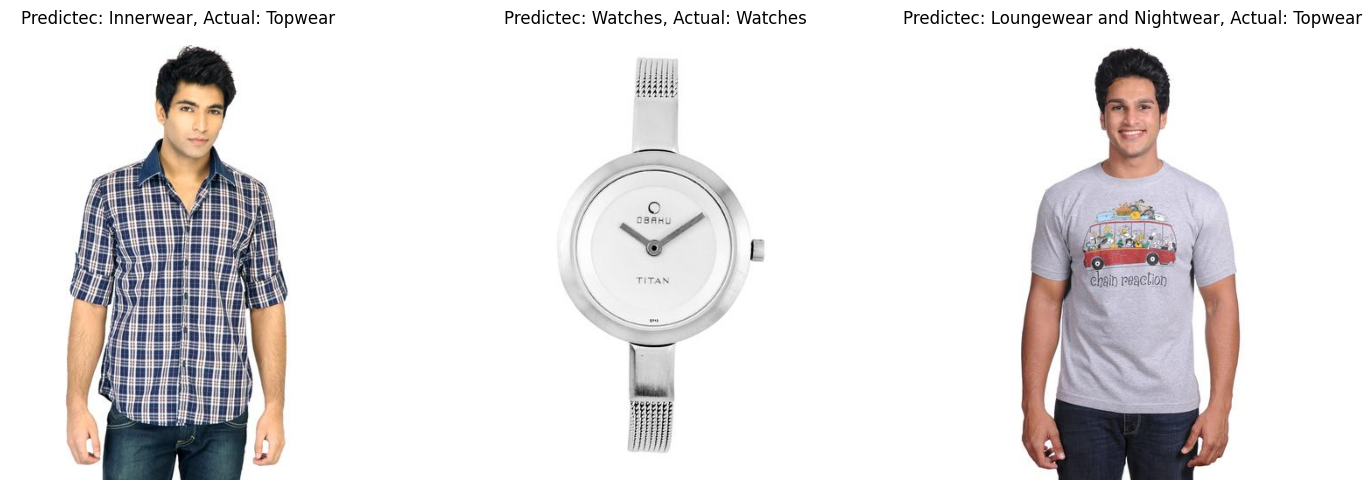

In [9]:
import matplotlib.pyplot as plt

indices = [0,2,5]

subcategories = list(set(example['subCategory'] for example in dataset))

text_inputs = torch.cat([clip.tokenize(f"a photo of {c}") for c in subcategories]).to(device)

fig, axes = plt.subplots(1, 3, figsize=(15,5))

for i, idx in enumerate(indices):
  example = dataset[idx]
  image = example['image']
  subcategory = example['subCategory']

  image_input = preprocess(image).unsqueeze(0).to(device)

  with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

  image_features/= image_features.norm(dim=-1, keepdim=True)
  text_features/= text_features.norm(dim=-1, keepdim=True)

  similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
  values, indices = similarity[0].topk(1)

  axes[i].imshow(image)
  axes[i].set_title(f"Predictec: {subcategories[indices[0]]}, Actual: {subcategory}")
  axes[i].axis('off')

plt.tight_layout()
plt.show()

In [10]:
from torch.utils.data import random_split

train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [11]:
from torchvision import transforms
from torch.utils.data import Dataset

class FashionDataset(Dataset):
  def __init__(self, data):
    self.data = data
    self.transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
    ])

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    item = self.data[idx]
    image = item['image']
    subcategory = item['subCategory']
    label = subcategories.index(subcategory)

    return self.transform(image), label

In [12]:
from torch.utils.data import DataLoader

train_loader = DataLoader(FashionDataset(train_dataset), batch_size=32, shuffle=True)
val_loader = DataLoader(FashionDataset(val_dataset), batch_size=32, shuffle=False)

In [13]:
class CLIPFineTuner(torch.nn.Module):
  def __init__(self, model, num_classes):
    super(CLIPFineTuner, self).__init__()
    self.model = model
    self.classifier = torch.nn.Linear(model.visual.output_dim, num_classes)


  def forward(self, x):
    with torch.no_grad():
      features = self.model.encode_image(x).float()
    return self.classifier(features)

In [14]:
num_classes = len(subcategories)
model_ft = CLIPFineTuner(model, num_classes).to(device)

In [15]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=1e-4)

In [16]:
from tqdm import tqdm

num_epochs = 5

for epoch in range(num_epochs):
  model_ft.train()
  running_loss = 0.0
  pbar = tqdm(train_loader, desc = f'Epoch {epoch + 1}/{num_epochs}, loss:0.0000')

  for images, labels in pbar:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model_ft(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    pbar.set_description(f'epoch {epoch+1}/{num_epochs}, loss: {running_loss/len(train_loader):.4f}')

  print(f'epoch [{epoch + 1}/{num_epochs}], loss: {running_loss/len(train_loader):.4f}')

  model_ft.eval()
  correct = 0
  total = 0

  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model_ft(images)
      _, predicted = torch.max(outputs.data, 1)
      total+= labels.size(0)
      correct += (predicted == labels).sum().item()

  print(f'validation accuracy: {100 * correct / total}%')

  torch.save(model_ft.state_dict(), 'clip_finetuned.pth')


epoch 1/5, loss: 1.5484: 100%|██████████| 1068/1068 [03:10<00:00,  5.60it/s]


epoch [1/5], loss: 1.5484
validation accuracy: 84.95316159250585%


epoch 2/5, loss: 0.5711: 100%|██████████| 1068/1068 [03:06<00:00,  5.72it/s]


epoch [2/5], loss: 0.5711
validation accuracy: 90.5503512880562%


epoch 3/5, loss: 0.3797: 100%|██████████| 1068/1068 [03:55<00:00,  4.53it/s]


epoch [3/5], loss: 0.3797
validation accuracy: 92.16627634660422%


epoch 4/5, loss: 0.2995: 100%|██████████| 1068/1068 [03:31<00:00,  5.06it/s]


epoch [4/5], loss: 0.2995
validation accuracy: 93.1615925058548%


epoch 5/5, loss: 0.2559: 100%|██████████| 1068/1068 [03:04<00:00,  5.80it/s]


epoch [5/5], loss: 0.2559
validation accuracy: 93.47775175644028%


<ipython-input-21-6f8beaa1ae28>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load('clip_finetuned.pth'))


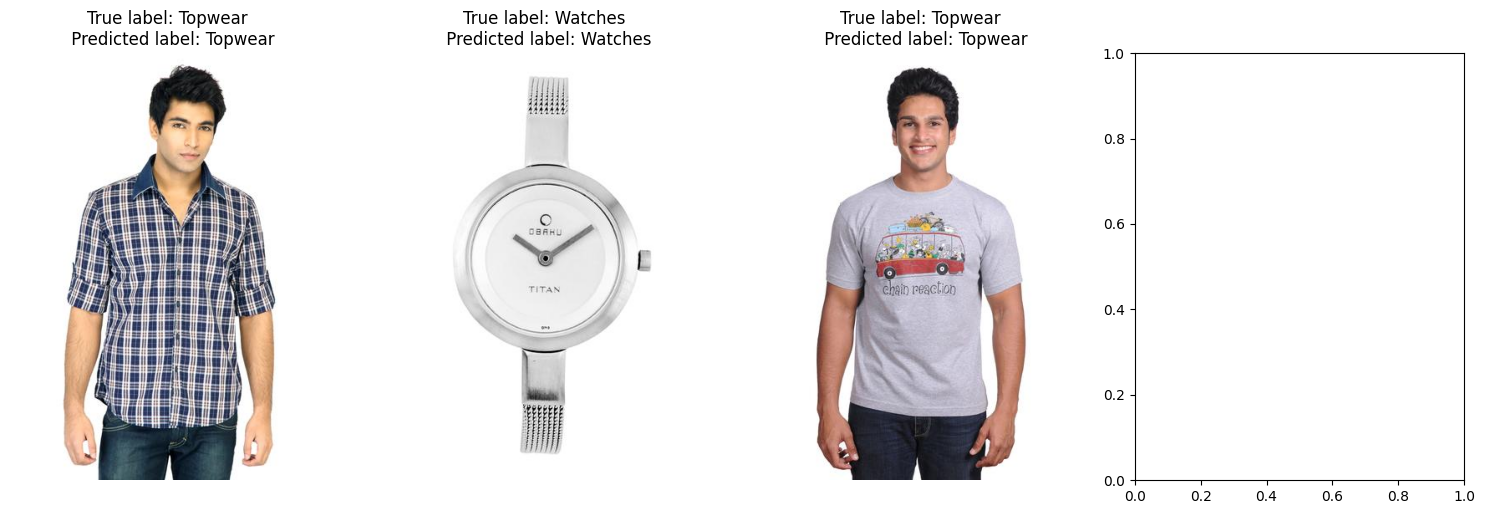

In [21]:
import matplotlib.pyplot as plt
import torch
from torchvision import disable_beta_transforms_warning

model_ft.load_state_dict(torch.load('clip_finetuned.pth'))
model_ft.eval()

indices = [0,2,5]

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

fig, axes = plt.subplots(1, 4, figsize=(15,5))

for i, idx in enumerate(indices):
  item = dataset[idx]
  image = item['image']
  true_label = item['subCategory']

  image_tensor = transform(image).unsqueeze(0).to(device)

  with torch.no_grad():
    output = model_ft(image_tensor)
    _, predicted_label_idx = torch.max(output, 1)
    predicted_label = subcategories[predicted_label_idx.item()]

  axes[i].imshow(image)
  axes[i].set_title(f'True label: {true_label} \n Predicted label: {predicted_label}')
  axes[i].axis('off')


plt.tight_layout()
plt.show()